<a href="https://colab.research.google.com/github/lingjzhu/probing-TTS-models/blob/master/TTS_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os.path import exists, join, expanduser

os.chdir(expanduser("~"))
tts_dir = 'probing-TTS-models'
if not exists(tts_dir):
  ! git clone https://github.com/lingjzhu/$tts_dir
  ! cd probing-TTS-models && git checkout && cd -
  
    

Cloning into 'probing-TTS-models'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 215 (delta 33), reused 0 (delta 0), pack-reused 154
Receiving objects: 100% (215/215), 2.90 MiB | 4.84 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Your branch is up to date with 'origin/master'.
/root


In [2]:
os.chdir('probing-TTS-models')

if not exists('models'):
  os.mkdir('models')
os.chdir('models')
!pwd

# download pre-trained WaveGlow
! wget -O waveglow_150k https://www.dropbox.com/s/vdy6aui6dg1ziyn/waveglow_150k?dl=0

# download pre-trained Tacotron 2 with BERT embeddings
! wget -O tacotron2_bert https://www.dropbox.com/s/bct9u8jimz049lg/tacotron2_bert?dl=0

# download pre-trained Tacotron 2
! wget -O tacotron2 https://www.dropbox.com/s/dn498owcg9wxcvq/tacotron2?dl=0

/root/probing-TTS-models/models
--2019-12-24 03:26:37--  https://www.dropbox.com/s/vdy6aui6dg1ziyn/waveglow_150k?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vdy6aui6dg1ziyn/waveglow_150k [following]
--2019-12-24 03:26:37--  https://www.dropbox.com/s/raw/vdy6aui6dg1ziyn/waveglow_150k
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7a6494826367d46e9bfbb4ccc.dl.dropboxusercontent.com/cd/0/inline/Au1x0XVj9d-jxgPxccTiWeUMxwKQXIMuX7XE2WM_rhnRQqbRgyGvVT-Uqjkg8FcX-lZNizN0-3-deN2f2H6nCTjpm1LyUdYedbSUQcEHAg_j8LQMDrJfSzG0UtRUbYwCk5Y/file# [following]
--2019-12-24 03:26:37--  https://ucb7a6494826367d46e9bfbb4ccc.dl.dropboxusercontent.com/cd/0/inline/Au1x0XVj9d-jxgPxccTiWeUMxwKQXIMuX7XE2WM_rhnRQqbRgyGvVT-Uqjkg8FcX-lZNizN

In [3]:
! gdown --id 1iNeYFhCBJWeUsIlnW_2K6SMwXkM4gLb_
! unzip chinese_wwm_ext_pytorch.zip
os.chdir('..')

Downloading...
From: https://drive.google.com/uc?id=1iNeYFhCBJWeUsIlnW_2K6SMwXkM4gLb_
To: /root/probing-TTS-models/models/chinese_wwm_ext_pytorch.zip
384MB [00:06, 56.2MB/s]
Archive:  chinese_wwm_ext_pytorch.zip
  inflating: bert_config.json        
  inflating: pytorch_model.bin       
  inflating: vocab.txt               


In [4]:
! pip install -q torch==1.1.0 torchvision==0.3.0
! pip install transformers pypinyin unidecode tensorboardX

     |████████████████████████████████| 676.9MB 25kB/s 
     |████████████████████████████████| 2.6MB 43.9MB/s 
     |████████████████████████████████| 450kB 9.6MB/s 
     |████████████████████████████████| 788kB 53.9MB/s 
     |████████████████████████████████| 245kB 40.2MB/s 
     |████████████████████████████████| 194kB 65.9MB/s 
     |████████████████████████████████| 860kB 59.8MB/s 
     |████████████████████████████████| 1.0MB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=873e282a6ef0d7d54f02c7564afe943c2d38bcdeb399a9b078ff9cc61b6498ff
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import os
import sys
sys.path.append('./waveglow/')
import numpy as np
import torch
import transformers

from hparams import create_hparams
from model import Tacotron2
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import text_normalize
from txt2pinyin import txt2pinyin

In [0]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [7]:
hparams = create_hparams()
# uncomment the following line if you want to use the original Tacotron 2
#hparams.bert = False
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
checkpoint_path = "./models/tacotron2_bert"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path))
_ = model.cuda().eval().half()

In [0]:
# specify the path to the pre-trained Waveglow
waveglow_path = './models/waveglow_150k'
waveglow = torch.load(waveglow_path)
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')
denoiser = Denoiser(waveglow)

In [0]:
def load_bert(path):
    '''
    Load the Chinese Bert model in the specified folder
    '''
    config_path = os.path.join(path,'bert_config.json')
    model_path = os.path.join(path,'pytorch_model.bin')
    vocab_path = os.path.join(path, 'vocab.txt')
    
    
    config = transformers.BertConfig.from_pretrained(config_path)
    config.output_hidden_states=True
    
    model = transformers.BertModel.from_pretrained(model_path,config=config)
    model.eval()
    
    tokenizer = transformers.BertTokenizer(vocab_path)
    
    return model, tokenizer


def extract_embeddings(model,tokenizer,text,upsampling=True):
    '''
    Extract embeddings from the pre-trained bert model.
    Apply upsampling to ensure that embedding length are the same as the phoneme length
    '''
    
    clean_text = text_normalize(text)
    pinyin_seq = txt2pinyin(clean_text)
    phon_seq = [i for syl in pinyin_seq for i in syl]
    
    inputs = torch.tensor(tokenizer.encode(clean_text)).unsqueeze(0)
    assert inputs[0,0]==101 and inputs[0,-1]==102
    outputs = model(inputs)    
    h = outputs[0].cpu().detach().numpy()
#    del outputs
    h = h[:,1:-1,:]
    assert h.shape[1] == len(pinyin_seq)

    features = [np.tile(h[:,i,:],[1,len(syl),1]) for i,syl in enumerate(pinyin_seq)]
    features = np.concatenate(features,axis=1)
    
    assert features.shape[1] == len(phon_seq)
    assert features.shape[2] == 768
    assert features.shape[0] == 1
    
    return torch.tensor(features).cuda().half()

if hparams.bert == True:
    # specify the path to the BERT folder
    bert_path = './models/'
    bert, tokenizer= load_bert(bert_path)

In [0]:
text = "刚出炉的烧鹅，呈现出枣红色的光泽，甘香油润，卤汁丰盈，放在任何的宴席上都是一道味彩出众的主菜。"
if text[-1] not in  ['。','？','！']:
    text += '。'
sequence = np.array(text_to_sequence(text, ['chinese_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
if hparams.bert == True:
    features = extract_embeddings(bert,tokenizer,text)
    sequence = (sequence, features)

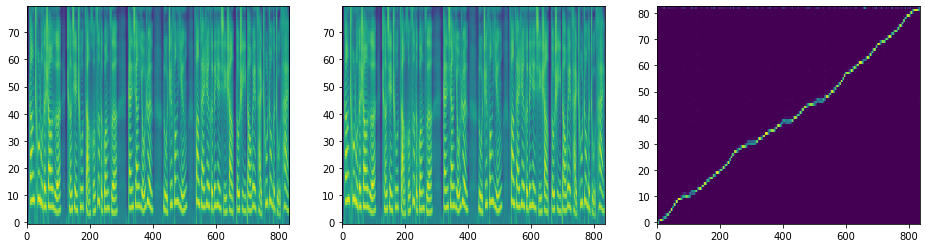

In [16]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [17]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

ipd.Audio(np.concatenate((np.zeros(2000),audio[0].data.cpu().numpy())), rate=hparams.sampling_rate)
